In [1]:
from sklearn.metrics import mean_absolute_error as MSE
from common import *
from models import *

In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")

price = df['NO2_price'].values.reshape(-1,1)
fload = df['NO2_load_forecasted'].values.reshape(-1,1)
agen = df['NO2_generation_forecast'].values.reshape(-1,1)
nve = df['NO2_Fyllingsgrad_NVE'].values.reshape(-1,1)

price_days = seperate_column_to_days(price)
fload_days = seperate_column_to_days(fload)
agen_days = seperate_column_to_days(agen)
nve_days = seperate_column_to_days(nve)

In [3]:
lookbehind = 14
input_width = lookbehind*24
horizon = 24
no_hours = input_width + horizon
hour_in_days = int(no_hours / 24)

price_dataset = []
fload_dataset = []
agen_dataset = []
nve_dataset = []
for i in range(len(price_days) - hour_in_days+1):
    price_dataset.append(np.concatenate((price_days[i:i+hour_in_days])))
    fload_dataset.append(np.concatenate((fload_days[i:i+hour_in_days])))
    agen_dataset.append(np.concatenate((agen_days[i:i+hour_in_days])))
    nve_dataset.append(np.concatenate((nve_days[i:i+hour_in_days])))

price_dataset = np.array(price_dataset)
fload_dataset = np.array(fload_dataset)
agen_dataset = np.array(agen_dataset)
nve_dataset = np.array(nve_dataset)

scaler = MinMaxScaler()
price_dataset = scaler.fit_transform(price_dataset[:,:,0])
price_dataset = price_dataset[..., np.newaxis].astype(np.float32)

fload_dataset = scaler.fit_transform(fload_dataset[:,:,0])
fload_dataset = fload_dataset[..., np.newaxis].astype(np.float32)

agen_dataset = scaler.fit_transform(agen_dataset[:,:,0])
agen_dataset = agen_dataset[..., np.newaxis].astype(np.float32)

nve_dataset = scaler.fit_transform(nve_dataset[:,:,0])
nve_dataset = nve_dataset[..., np.newaxis].astype(np.float32)

dataset = np.concatenate((price_dataset, fload_dataset, agen_dataset, nve_dataset), axis=2)
#dataset = price_dataset
n,m,k = dataset.shape
print(n,m,k)

2138 360 4


In [4]:
train = int(0.7*n)
valid = int(0.9*n)
X_train, y_train = dataset[:train, :input_width, :-1], dataset[:train, -horizon:, :1]
X_valid, y_valid = dataset[train:valid, :input_width, :-1], dataset[train:valid, -horizon:, :1]
X_test, y_test = dataset[valid:, :input_width, :-1], dataset[valid:, -horizon:, :1]

print(f"{X_train.shape=}")
print(f"{X_valid.shape=}")
print(f"{X_test.shape=}")

print(f"{y_train.shape=}")
print(f"{y_valid.shape=}")
print(f"{y_test.shape=}")

X_train.shape=(1496, 336, 3)
X_valid.shape=(428, 336, 3)
X_test.shape=(214, 336, 3)
y_train.shape=(1496, 24, 1)
y_valid.shape=(428, 24, 1)
y_test.shape=(214, 24, 1)


In [5]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, k-1]),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(horizon)
])

2021-12-14 17:55:52.435602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-14 17:55:52.477806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-14 17:55:52.477824: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-14 17:55:52.479016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [6]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
epochs = 10
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [7]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/10
47/47 [==============================] - 8s 151ms/step - loss: 0.0447 - last_time_step_mse: 0.0899 - val_loss: 0.0142 - val_last_time_step_mse: 0.0351
Epoch 2/10
47/47 [==============================] - 7s 144ms/step - loss: 0.0024 - last_time_step_mse: 0.0244 - val_loss: 0.0043 - val_last_time_step_mse: 0.0415
Epoch 3/10
47/47 [==============================] - 7s 148ms/step - loss: 0.0011 - last_time_step_mse: 0.0212 - val_loss: 0.0025 - val_last_time_step_mse: 0.0288
Epoch 4/10
47/47 [==============================] - 7s 150ms/step - loss: 8.5075e-04 - last_time_step_mse: 0.0189 - val_loss: 0.0023 - val_last_time_step_mse: 0.0270
Epoch 5/10
47/47 [==============================] - 8s 161ms/step - loss: 7.5617e-04 - last_time_step_mse: 0.0180 - val_loss: 0.0020 - val_last_time_step_mse: 0.0294
Epoch 6/10
47/47 [==============================] - 7s 151ms/step - loss: 7.5758e-04 - last_time_step_mse: 0.0177 - val_loss: 0.0021 - val_last_time_step_mse: 0.0359
Epoch 7/10
47/47

In [8]:
y_pred = model.predict(X_test)

In [9]:
print(MSE(y_test[:,:,0], y_pred))

0.09825634


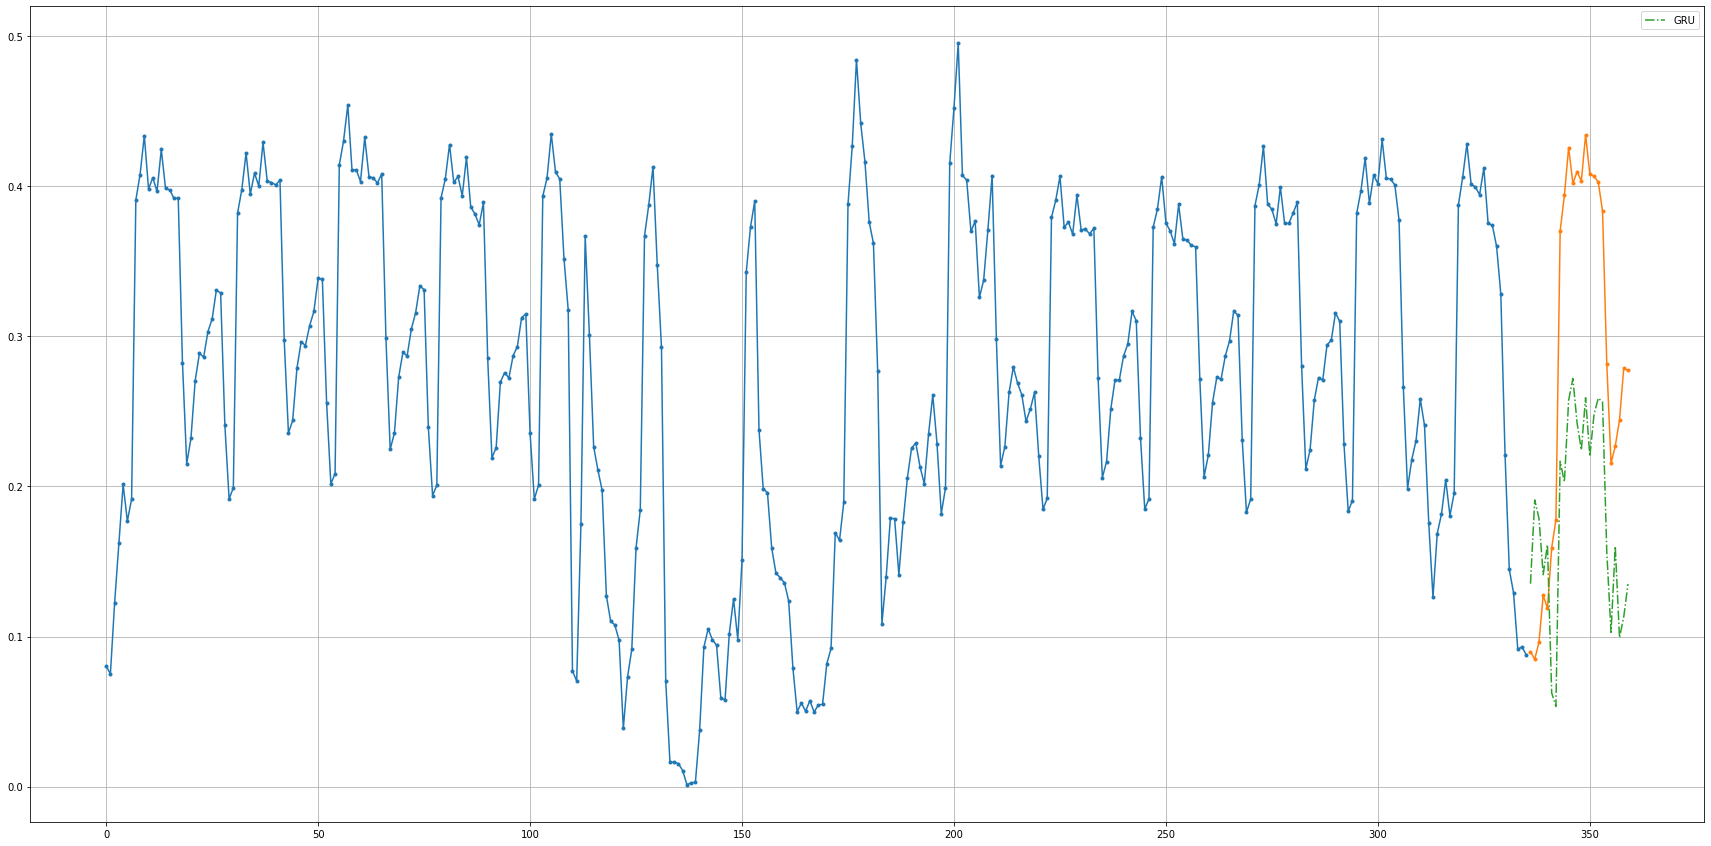

In [10]:
x = np.arange(no_hours)
plt.figure(figsize=(30,15))
plt.plot(x[:no_hours-horizon], X_test[36,:,0].flatten(), '.-')
plt.plot(x[-horizon:], y_test[36,:,0].flatten(), '.-')
plt.plot(x[-horizon:], y_pred[36].flatten(), '-.', label="GRU")
#plt.plot(x[-horizon:], Y_pred_ln[36].flatten(), '-.', label="LayerNorm")
#plt.plot(x[-horizon:], Y_pred_lstm[36].flatten(), '-.', label="LSTM")
plt.legend()
plt.grid()
plt.show()